In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.mixture import BayesianGaussianMixture

import matplotlib.pyplot as plt
import time
import scipy
pd.options.display.float_format = "{:,.4f}".format

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
X = scipy.sparse.load_npz('data/train_steps_vec.npz')

In [4]:
test = scipy.sparse.load_npz('data/test_steps_vec.npz')

In [5]:
test.shape

(10000, 17967)

In [6]:
data = pd.read_csv("data/recipe_train.csv")

In [7]:
testingSet = pd.read_csv("data/recipe_test.csv")

In [8]:
testingSet.shape

(10000, 8)

In [9]:
y = data["duration_label"]

In [10]:
y

0       2.0000
1       2.0000
2       2.0000
3       2.0000
4       2.0000
5       2.0000
6       2.0000
7       3.0000
8       2.0000
9       2.0000
10      1.0000
11      2.0000
12      2.0000
13      2.0000
14      2.0000
15      2.0000
16      2.0000
17      2.0000
18      2.0000
19      3.0000
20      2.0000
21      1.0000
22      1.0000
23      1.0000
24      1.0000
25      2.0000
26      2.0000
27      2.0000
28      1.0000
29      1.0000
         ...  
39970   1.0000
39971   1.0000
39972   2.0000
39973   1.0000
39974   1.0000
39975   1.0000
39976   3.0000
39977   1.0000
39978   2.0000
39979   2.0000
39980   3.0000
39981   2.0000
39982   2.0000
39983   3.0000
39984   1.0000
39985   2.0000
39986   1.0000
39987   1.0000
39988   1.0000
39989   2.0000
39990   1.0000
39991   1.0000
39992   1.0000
39993   1.0000
39994   1.0000
39995   1.0000
39996   2.0000
39997   1.0000
39998   2.0000
39999   2.0000
Name: duration_label, Length: 40000, dtype: float64

In [11]:
D = pd.read_csv('data/train_steps_doc2vec50.csv', header = None, index_col = False)

In [12]:
Dt = pd.read_csv('data/test_steps_doc2vec50.csv', header = None, index_col = False)

In [13]:
D1 = pd.read_csv('data/train_steps_doc2vec100.csv', header = None, index_col = False)

In [14]:
D1t = pd.read_csv('data/test_steps_doc2vec100.csv', header = None, index_col = False)

In [15]:
Dt.shape

(10000, 50)

In [16]:
D1t.shape

(10000, 100)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [18]:
D_train, D_test, Dy_train, Dy_test = train_test_split(D, y, test_size=0.2, random_state=88)

In [19]:
D1_train, D1_test, D1y_train, D1y_test = train_test_split(D, y, test_size=0.2, random_state=88)

In [20]:
vt = VarianceThreshold(0.01)
X_train = vt.fit_transform(X_train, y_train)
X_test = vt.transform(X_test)

In [21]:
X_vt = vt.fit_transform(X, y)

In [22]:
test_vt = vt.transform(test) 

In [23]:
print(X_vt.shape)

(40000, 888)


In [24]:
C= 3.7
k = 600

In [25]:
models = [GaussianNB(),
          MultinomialNB(),
          DecisionTreeClassifier(max_depth=1),
          DecisionTreeClassifier(max_depth=None),
          svm.LinearSVC(C=C),
          LogisticRegression()]
titles = ['GNB',
          'MNB',
          'one-r',
          'Decision Tree',
          'LinearSVC',
          'Logistic Regression']

In [26]:
x2 = SelectFdr(chi2, alpha = 0.01)
x2.fit(X_train,y_train)
X_train_x2 = x2.transform(X_train)
X_test_x2 = x2.transform(X_test)

In [27]:
print(X_train_x2.shape)

(32000, 757)


In [28]:
f = SelectFdr(f_classif, alpha = 0.01)
f.fit(X_train,y_train)
X_train_f = f.transform(X_train)
X_test_f = f.transform(X_test)

In [29]:
print(X_train_f.shape)

(32000, 705)


In [30]:
mi = SelectKBest(mutual_info_classif, k = k)
mi.fit(X_train,y_train)
X_train_mi = mi.transform(X_train)
X_test_mi = mi.transform(X_test)

In [31]:
print(X_train_mi.shape)

(32000, 600)


In [66]:
%%time
Xs = [(X_train, X_test), (X_train_x2, X_test_x2), (X_train_f, X_test_f), (X_train_mi, X_test_mi)]

X_names = ['complete', 'x2', 'f', 'mi']

for title, model in zip(titles, models):
    print('\n',title, '(with k=',k,'features):')
    for X_name, Xt in zip(X_names, Xs):
        X_train_t, X_test_t = Xt
        model.fit(X_train_t.todense(), y_train)
        acc = model.score(X_test_t.todense(), y_test)
        print(X_name, '\t acc',  acc)


 GNB (with k= 586 features):
complete 	 acc 0.511
x2 	 acc 0.56275
f 	 acc 0.6
mi 	 acc 0.616875

 MNB (with k= 586 features):
complete 	 acc 0.714875
x2 	 acc 0.71125
f 	 acc 0.709875
mi 	 acc 0.70825

 one-r (with k= 586 features):
complete 	 acc 0.65475
x2 	 acc 0.65475
f 	 acc 0.65475
mi 	 acc 0.65475

 Decision Tree (with k= 586 features):
complete 	 acc 0.72625
x2 	 acc 0.726375
f 	 acc 0.72425
mi 	 acc 0.72675

 LinearSVC (with k= 586 features):
complete 	 acc 0.788375
x2 	 acc 0.78975
f 	 acc 0.789875
mi 	 acc 0.788

 Logistic Regression (with k= 586 features):
complete 	 acc 0.7925
x2 	 acc 0.788125
f 	 acc 0.78975
mi 	 acc 0.793875
Wall time: 3min 22s


In [ ]:
models = [LogisticRegression(),
          Ridge(0.01),
          Lasso(0.01)]
titles = ['Logistic Regression',
          '',
          '']

In [126]:
%%time
lst = []
model = LogisticRegression()
for k in range(500, 801, 25):
    mi = SelectKBest(mutual_info_classif, k = k)
    mi.fit(X_vt,y)
    X_vt_mi = mi.transform(X_vt)
    acc = cross_val_score(model, X_vt_mi, y, cv = 4)
    print(k, acc)
    lst.append(acc.mean())

500 [0.7924 0.7881 0.7957 0.7991]
525 [0.7911 0.7863 0.7962 0.7993]
550 [0.7911 0.7871 0.7949 0.798 ]
575 [0.7913 0.7869 0.7945 0.796 ]
600 [0.7925 0.7914 0.7982 0.8012]
625 [0.792  0.7916 0.7977 0.801 ]
650 [0.7923 0.7906 0.7988 0.8003]
675 [0.7924 0.7917 0.7995 0.7997]
700 [0.7928 0.7944 0.7998 0.7984]
725 [0.7931 0.7942 0.7997 0.7992]
750 [0.7932 0.7948 0.8001 0.8002]
775 [0.7912 0.7931 0.7994 0.7996]
800 [0.7925 0.7942 0.7998 0.8022]
Wall time: 2min 48s


In [44]:
plt.plot(range(500, 801, 25), lst)

NameError: name 'lst' is not defined

In [23]:
MNB = MultinomialNB()
MNB.fit(X, y)
MNB_predicted = MNB.predict(test)
MNB.score(X,y)

0.751825

In [17]:
X_vt.shape

(40000, 888)

In [26]:
mi = SelectKBest(mutual_info_classif, k = 874)
X_vt_mi = mi.fit_transform(X_vt, y)
test_vt_mi = mi.transform(test_vt)

In [27]:
%%time
rc = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv = 5)
rc.fit(X_vt_mi, y)
rc_mi = rc.score(X_vt_mi,y)
rc_mi

Wall time: 9.95 s


0.802175

In [39]:
len(range(600, 889, 22))

14

In [49]:
%%time
score = []
for k in range(1000, 1900, 100):
    mi = SelectKBest(mutual_info_classif, k = k)
    mi.fit(X_f,y)
    X_f_mi = mi.transform(X_f)
    rc.fit(X_f_mi, y)
    acc = rc.score(X_f_mi,y)
    print(k, acc)
    score.append(acc.mean())

1000 0.80335
1100 0.8049
1200 0.8063
1300 0.80785
1400 0.80875
1500 0.8098
1600 0.81105
1700 0.811575
1800 0.812375
Wall time: 9min 43s


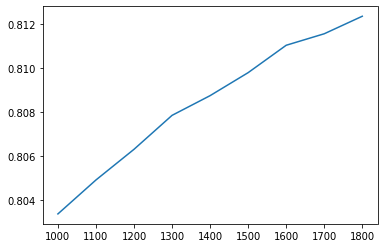

In [50]:
plt.plot(range(1000, 1900, 100), score)

In [55]:
f.fit(X_vt, y)
X_vt_f = f.transform(X_vt)
rc.fit(X_vt_f, y)
rc_f = rc.score(X_vt_f,y)

In [41]:
f.fit(X, y)
X_f = f.transform(X)
test_f = f.transform(test)
rc.fit(X_f, y)
rc_f = rc.score(X_f, y)
print(X_f.shape, rc_f)

(40000, 1817) 0.811775


In [30]:
x2.fit(X, y)
X_x2 = x2.transform(X)
test_x2 = x2.transform(test)
rc.fit(X_x2, y)
rc_x2 = rc.score(X_x2, y)
print(X_x2.shape, rc_x2)

(40000, 2069) 0.814825


In [36]:
mi = SelectKBest(mutual_info_classif, k = 1000)
X_mi = mi.fit_transform(X, y)
test_mi = mi.transform(test)

In [38]:
rc.fit(X_mi, y)
rc_mi = rc.score(X_mi, y)
print(X_mi.shape, rc_mi)

(40000, 1000) 0.804075


In [43]:
mi = SelectKBest(mutual_info_classif, k = 1000)
X_f_mi = mi.fit_transform(X_f, y)
test_f_mi = mi.transform(test_f)
rc.fit(X_f_mi, y)
rc_f_mi = rc.score(X_f_mi, y)
print(X_f_mi.shape, rc_f_mi)

(40000, 1000) 0.80335


In [50]:
print(X_vt_f.shape)

(40000, 734)


In [60]:
x2.fit(X_vt,y)
X_vt_x2 = x2.transform(X_vt)
test_vt_x2 = x2.transform(test_vt)
rc.fit(X_vt_x2, y)
rc_x2 = rc.score(X_vt_x2,y)
rc_x2

0.8004

In [51]:
print(X_vt_x2.shape)

(40000, 780)


In [51]:
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X,y)
lasso.score(X,y)

0.44762798568323214

In [22]:
rc_predicted=rc.predict(test_vt)

In [54]:
test_vt_f = f.transform(test_vt)
print(test_vt_f.shape)

(10000, 734)


In [31]:
rc_x2_predicted = rc.predict(test_x2)

In [74]:
rc_f_predicted = rc.predict(test_f)

In [39]:
rc_mi_predicted = rc.predict(test_mi)

In [44]:
rc_f_mi_predicted = rc.predict(test_f_mi)

In [62]:
rc_vt_x2_predicted = rc.predict(test_vt_x2)

In [68]:
rc_vt_mi_predicted = rc.predict(test_vt_mi)

In [ ]:
log_predicted = 

In [100]:
testingSet.index

RangeIndex(start=0, stop=10000, step=1)

In [56]:
knn5 = KNeighborsClassifier(n_neighbors=99)
knn5.fit(D_train, Dy_train)
knn5.score(D_test, Dy_test)

0.59325

In [32]:
kscore=[]
for k in range(5, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(D1_train, D1y_train)
    acc = knn.score(D1_test, D1y_test)
    print(k, acc)
    kscore.append(acc)

5 0.62625
7 0.627625
9 0.62625
11 0.627125
13 0.626125
15 0.630125
17 0.6295
19 0.6285
21 0.627875
23 0.626625
25 0.626625
27 0.62325
29 0.625125
31 0.6235
33 0.623
35 0.622375
37 0.62225
39 0.620875
41 0.61975
43 0.61825
45 0.61575
47 0.613375
49 0.613375


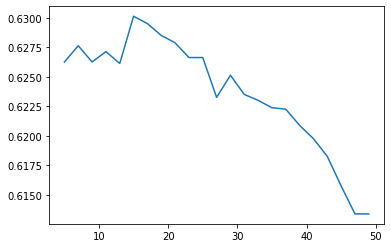

In [33]:
plt.plot(range(5, 50, 2), kscore)

In [61]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D,y)
knn15_predicted = knn15.predict(Dt)

In [64]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D1,y)
knn15_predicted = knn15.predict(D1t)

In [62]:
knn15_predicted

array([1., 1., 1., ..., 1., 1., 2.])

In [43]:
D_train_f = f.fit_transform(D_train, Dy_train)
D_test_f = f.transform(D_test)
print(D_train_f.shape)
knn5.fit(D_train_f, Dy_train)
print(knn5.score(D_test_f, Dy_test))

(32000, 49)
0.6205


In [35]:
scale_svm = make_pipeline(StandardScaler(),svm.LinearSVC(random_state=0, tol=1e-5, multi_class = 'crammer_singer'))
scale_svm.fit(D_train, Dy_train)
scale_svm.score(D_test, Dy_test)

0.6435

In [36]:
scale_svm.fit(D1_train, D1y_train)
scale_svm.score(D1_test, D1y_test)

0.6435

In [38]:
scale_svm.fit(X_train.todense(), y_train)
scale_svm.score(X_test.todense(), y_test)

0.774875

In [51]:
knn5 = KNeighborsClassifier(n_neighbors=201)
knn5.fit(D1_train, D1y_train)
knn5.score(D1_test, D1y_test)

0.567875

In [27]:
bgm = BayesianGaussianMixture(n_components=3, random_state=42)
bgm.fit(D_train, y = Dy_train)
bgm.score(D_test, Dy_test)

-49.98054772526579

In [28]:
bgm.predict(D_test)

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [26]:
Dy_test

6468    1.0000
18232   2.0000
2401    1.0000
33478   2.0000
10700   2.0000
11408   1.0000
9341    1.0000
6983    2.0000
12891   2.0000
27127   2.0000
24597   1.0000
23328   2.0000
3366    1.0000
17341   2.0000
25383   2.0000
20402   2.0000
37971   2.0000
39517   2.0000
35263   1.0000
28672   1.0000
16148   1.0000
11199   3.0000
15207   2.0000
7391    1.0000
13043   1.0000
804     2.0000
22049   2.0000
34996   1.0000
441     2.0000
20168   3.0000
         ...  
39815   1.0000
8712    2.0000
22274   2.0000
21197   2.0000
39533   2.0000
23634   3.0000
16350   1.0000
27145   2.0000
27338   2.0000
27340   2.0000
15709   1.0000
33132   3.0000
27957   1.0000
32478   2.0000
26306   1.0000
19587   2.0000
32358   1.0000
24244   1.0000
38754   3.0000
20548   2.0000
5550    1.0000
23659   2.0000
24744   1.0000
12466   2.0000
3073    3.0000
25868   1.0000
8417    1.0000
21958   1.0000
8886    3.0000
6657    2.0000
Name: duration_label, Length: 8000, dtype: float64

In [42]:
a = [(1,2),(3,4),(5,6)]
a[-1][-1]

6

In [41]:


classifiers = [KNeighborsClassifier(n_neighbors=15),
                KNeighborsClassifier(n_neighbors=15),
                MultinomialNB()]
Datas=[((D_train, Dy_train),(D_test, Dy_test)),((D1_train, D1y_train),(D1_test, D1y_test)),((X_train, y_train),(X_test,y_test))]


In [54]:
%%time
for Data,clf in zip(Datas,classifiers):
    trainin = Data[0]
    testin = Data[1]
    clf.fit(trainin[0],trainin[1])
    print("Accuracy:",clf.score(testin[0],testin[1]))
    

Accuracy: 0.630125
Accuracy: 0.630125
Accuracy: 0.714875
Wall time: 12 s


In [53]:
%%time
base1 = KNeighborsClassifier(n_neighbors=15)
base2 = KNeighborsClassifier(n_neighbors=15)
base3 = MultinomialNB()
metaclassifier = LogisticRegression()

base1.fit(D_train, Dy_train)
base2.fit(D1_train, D1y_train)
base3.fit(X_train, y_train)

yhats = [base1.predict_proba(D_train),base2.predict_proba(D1_train),base3.predict_proba(X_train)]
yhats = np.concatenate(yhats, axis=1)
assert yhats.shape[0] == X_train.shape[0]

metaclassifier.fit(yhats, y_train)

yhats = [base1.predict_proba(D_test),base2.predict_proba(D1_test),base3.predict_proba(X_test)]
yhats = np.concatenate(yhats, axis=1)
assert yhats.shape[0] == X_test.shape[0]
yhat = metaclassifier.predict(yhats)

print(accuracy_score(y_test, yhat))

0.722375
Wall time: 1min 8s


In [50]:
print(X_train.shape[0]) == print(D_train.shape[0]) == print(D1_train.shape[0])

32000
32000
32000


True

In [66]:
predicted = pd.DataFrame({'id':testingSet.index+1, 'duration_label':knn15_predicted})
predicted.to_csv('predicted.csv', index = False)

In [113]:
predicted

,id,duration_label
0,1,2.0000
1,2,1.0000
2,3,1.0000
3,4,1.0000
4,5,2.0000
5,6,1.0000
6,7,2.0000
7,8,1.0000
8,9,1.0000
9,10,2.0000
